In [ ]:
import os
from pathlib import Path
import glob
import openslide
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# Select random slide

In [ ]:
home_dir = os.getenv("HOME")
data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")

table_dir = os.path.join(data_dir, "v2")

slide_dir = os.path.join(data_dir, "ndpi")
slides_fp = os.path.join(slide_dir, "*")
slides_list = glob.glob(slides_fp)

In [ ]:
random.seed(123)
random_slide_path = random.choice(slides_list)
random_slide_id = Path(random_slide_path).stem

# Select random biopsy

Load slide biopsy map

In [ ]:
slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

In [ ]:
random.seed(123)
random_biopsy_id = random.choice(slide_biopsy_map_df["biopsy_id"].unique())
slide_ids = slide_biopsy_map_df[slide_biopsy_map_df["biopsy_id"] == random_biopsy_id][
    "slide_id"
].values
slide_ids.sort()

# Helper functions

In [ ]:
def load_slide_biopsy_map():
    home_dir = os.getenv("HOME")
    data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")
    table_dir = os.path.join(data_dir, "v2")
    slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
    slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

    return slide_biopsy_map_df


def get_slide_file_path(slide_id):
    home_dir = os.getenv("HOME")
    data_dir = os.path.join(home_dir, "datasets", "brca-psj-path")
    slide_dir = os.path.join(data_dir, "ndpi")
    slide_fp = os.path.join(slide_dir, f"{slide_id}.ndpi")

    return slide_fp


def slide_paths_for_biopsy_id(biopsy_id):
    slide_biopsy_map_df = load_slide_biopsy_map()
    slide_id_list = slide_biopsy_map_df[slide_biopsy_map_df["biopsy_id"] == biopsy_id][
        "slide_id"
    ].values

    slide_paths = []
    for slide_id in slide_id_list:
        slide_path = get_slide_file_path(slide_id)
        slide_paths.append(slide_path)

    return slide_paths


def preview_slide(slide_path):
    slide_OS = openslide.OpenSlide(slide_path)
    lowest_res = slide_OS.level_dimensions[-1]

    return slide_OS.get_thumbnail(lowest_res)


def get_all_previews_for_biopsy_id(biopsy_id):
    preview_images = dict()
    slide_fp_list = slide_paths_for_biopsy_id(biopsy_id)
    print(f"This could take up to {len(slide_fp_list)*10} seconds.")

    for filepath in tqdm(slide_fp_list):
        slide_id = Path(filepath).stem
        preview_images[slide_id] = preview_slide(filepath)

    return preview_images


def show_slides_for_biopsy_id(biopsy_id, columns=3):
    preview_images = get_all_previews_for_biopsy_id(biopsy_id)
    img_count = len(preview_images)

    rows = math.ceil(img_count / columns)
    figsize = (columns * 7, rows * 7)

    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    axs = axs.flatten()
    for ax, (slide_id, img) in zip(axs, preview_images.items()):
        ax.imshow(img)
        ax.set_title(slide_id)
    for ax in axs:
        ax.axis("off")


def random_points(n, width, height, seed="123"):
    random.seed(seed)
    pts = []
    for _ in range(n):
        x = random.randrange(0, width - 256)
        y = random.randrange(0, height - 256)
        pts.append((x, y))

    return pts


def show_random_patches_slide(slide_id, seed="123"):
    slide_fp = get_slide_file_path(slide_id)
    slide_OS = openslide.OpenSlide(slide_fp)
    res = slide_OS.dimensions
    random_pts = random_points(15, *res, seed=seed)
    patch_size = (256, 256)

    display(preview_slide(slide_fp))

    pts = iter(random_pts)

    fig, axs = plt.subplots(5, 3, figsize=(15, 25))
    for i in range(5):
        for j in range(3):
            pt = next(pts)
            im = slide_OS.read_region(pt, 0, patch_size)
            axs[i, j].imshow(im)
            axs[i, j].axis("off")

This could take up to 40 seconds.


100%|██████████| 4/4 [01:16<00:00, 19.22s/it]


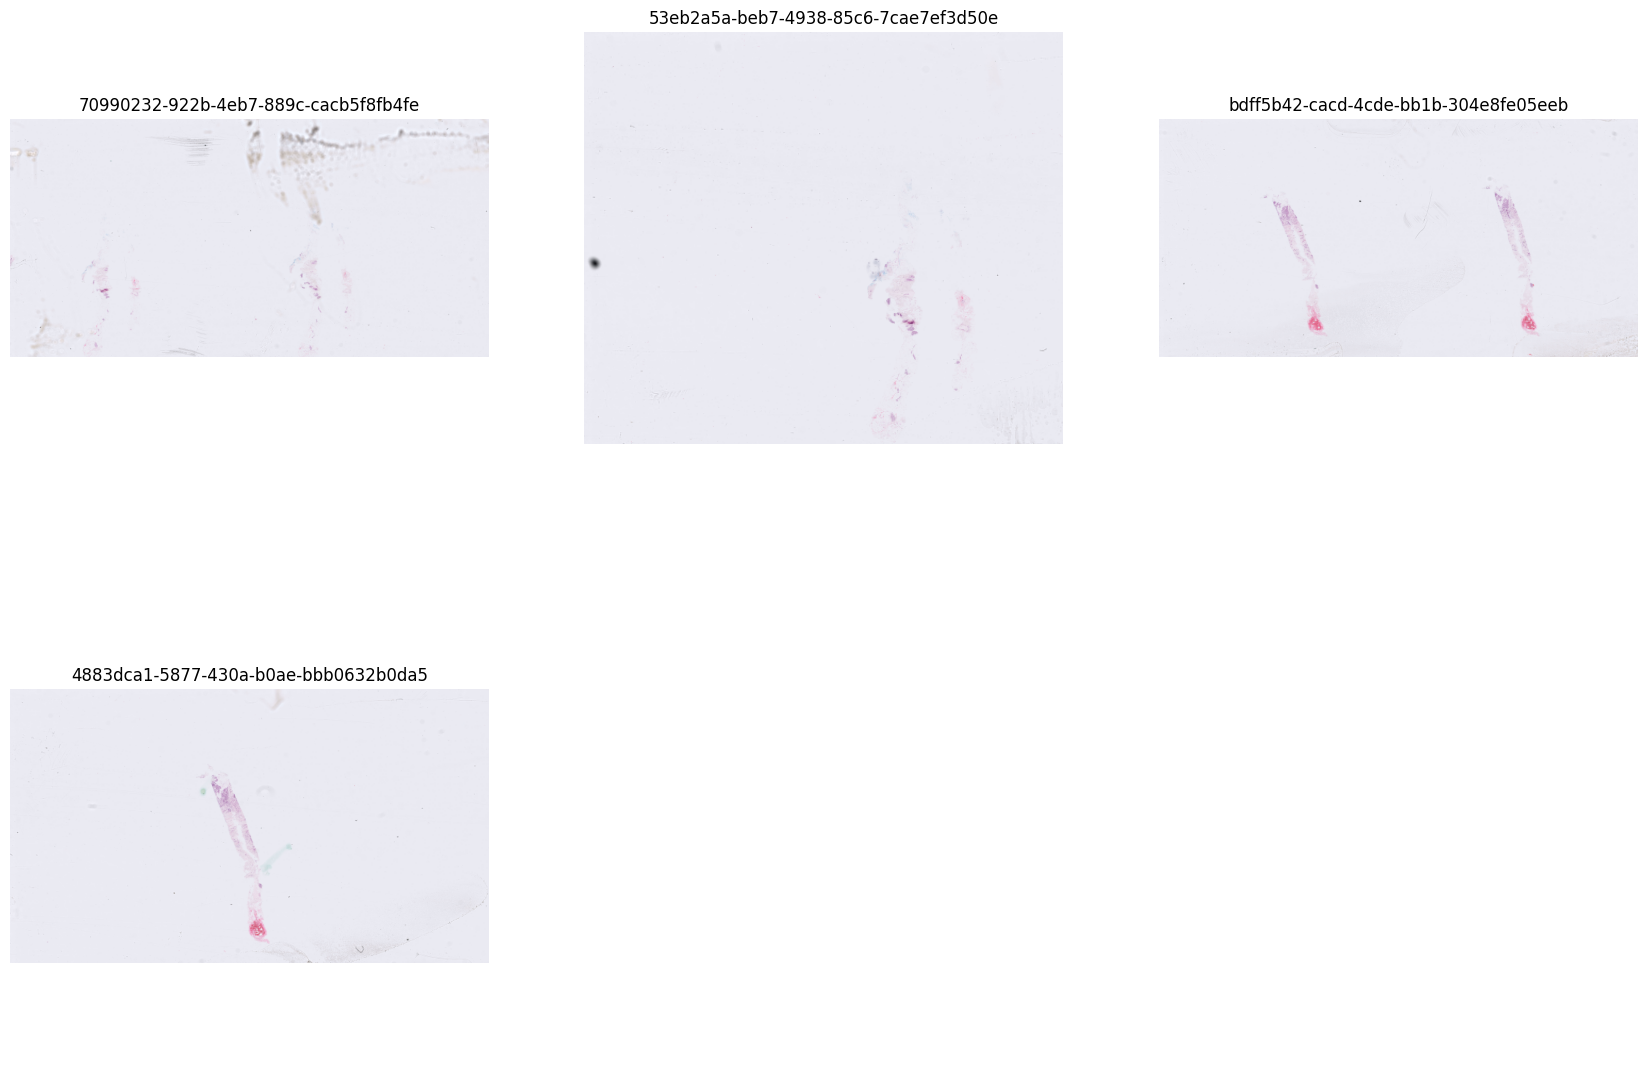

In [ ]:
show_slides_for_biopsy_id(random_biopsy_id)

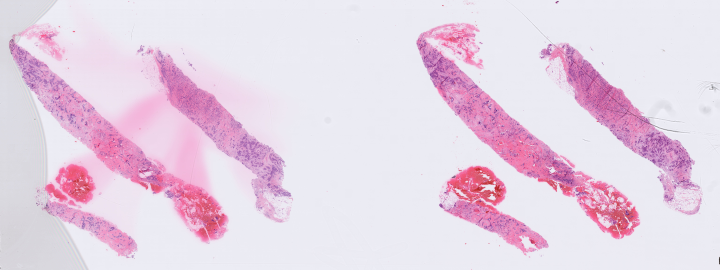

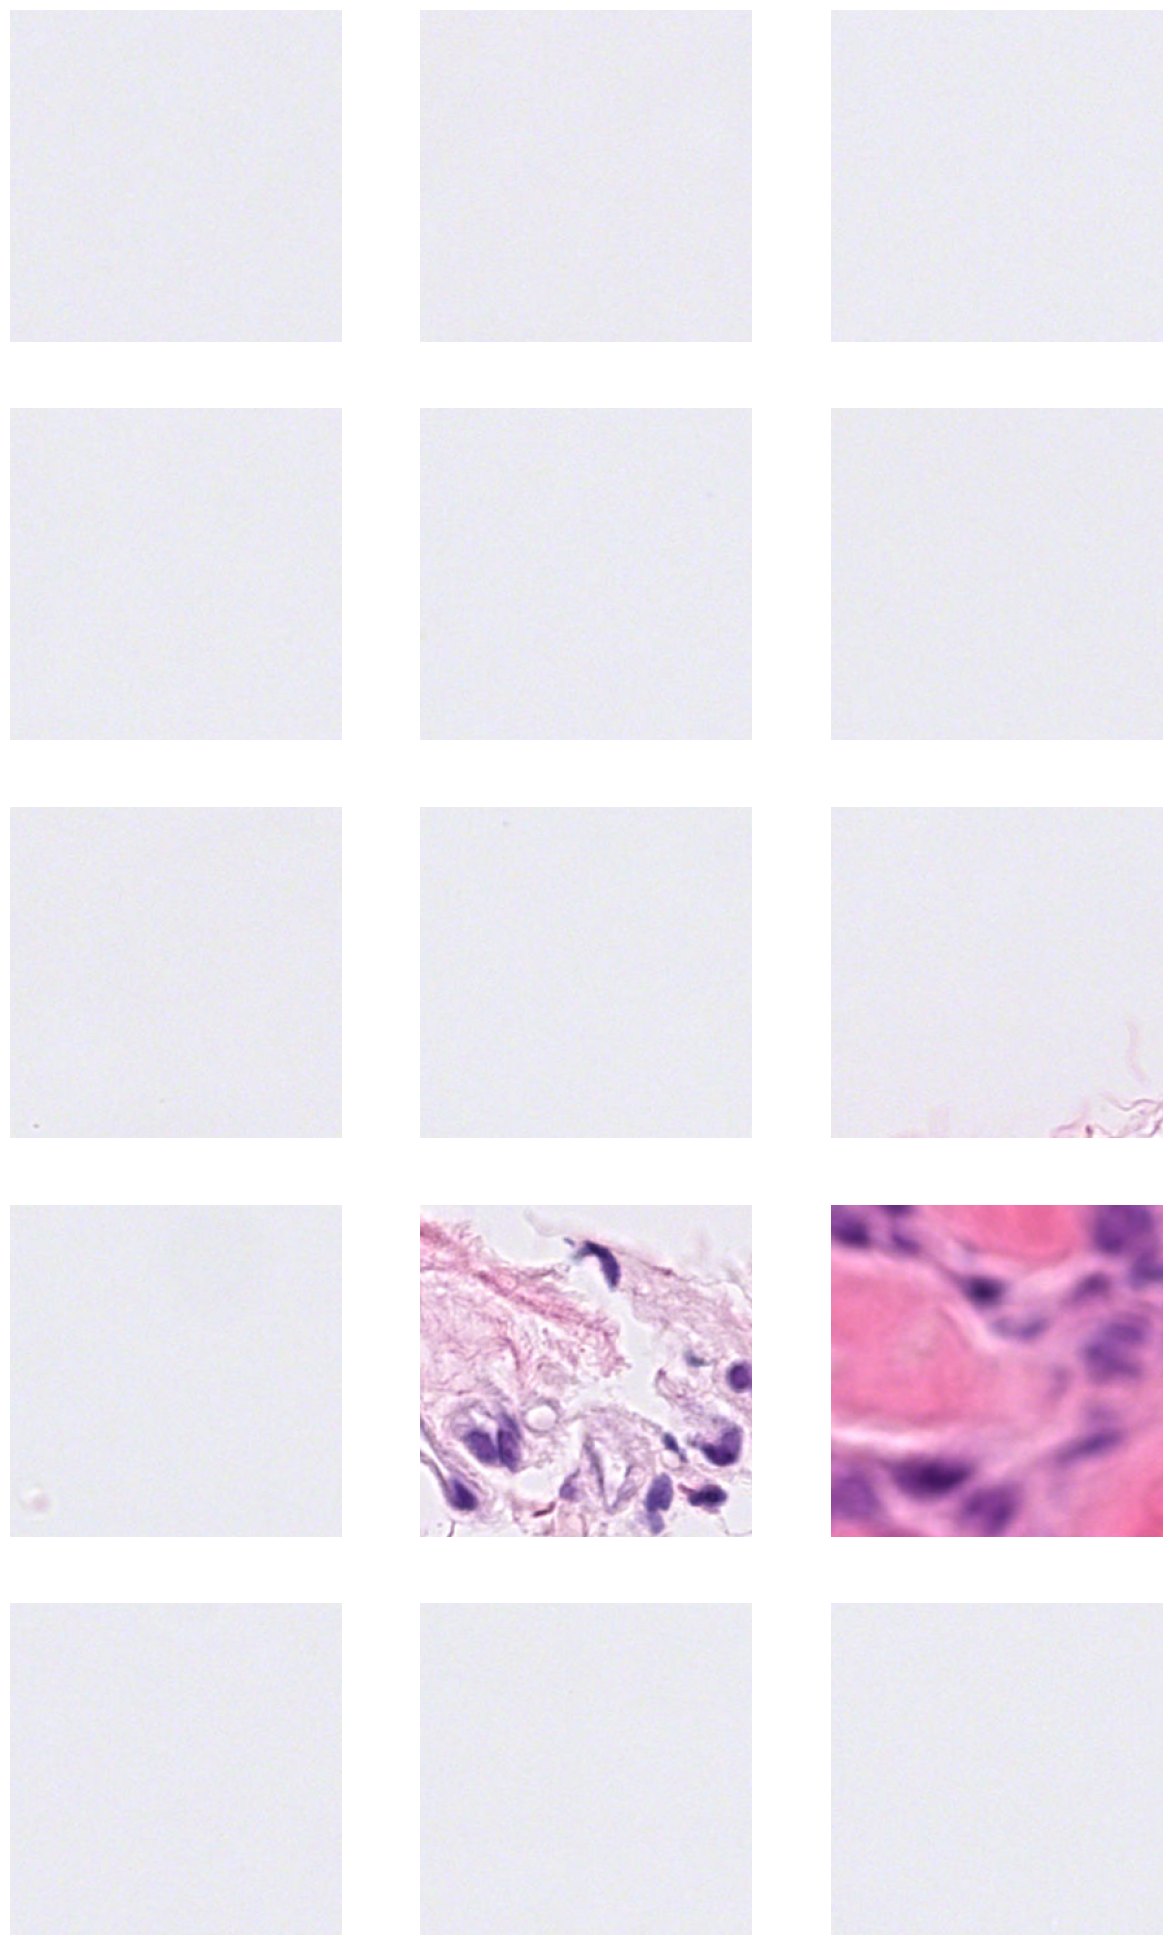

In [ ]:
show_random_patches_slide(random_slide_id, seed="234")

# Plotting Our Data

In [ ]:
# load metastatic diagnosis csv and outcomes csv into dataframe
metastatic_dx_fp = os.path.join(table_dir, "cancer-dx.csv")
metastatic_dx_df = pd.read_csv(metastatic_dx_fp)
metastatic_dx_df["dx_dt"] = pd.to_datetime(metastatic_dx_df.dx_dt)

outcomes_fp = os.path.join(table_dir, "outcomes.csv")
outcomes_df = pd.read_csv(outcomes_fp)
outcomes_df["biopsy_dt"] = pd.to_datetime(outcomes_df.biopsy_dt)

metastatic_dx_df = metastatic_dx_df.merge(
    outcomes_df[["biopsy_id", "biopsy_dt"]], on="biopsy_id", how="left"
)

metastatic_dx_df["time_to_dx"] = (
    metastatic_dx_df.dx_dt - metastatic_dx_df.biopsy_dt
).dt.days

Below we show an example of a patient's biopsy and diagnosis history from `outcomes.csv`.

In [ ]:
example_patient_df = outcomes_df[
    outcomes_df["patient_ngsci_id"] == "c9401ed1-f387-4b7b-8ee2-d67402a1f751"
]
example_patient_df

,biopsy_id,patient_ngsci_id,case_year,biopsy_dt,mortality,death_dt,in_registry,stage,strict_metastatic_dx,strict_metastatic_dx_dt
1067,5332879e-4a75-48cb-8f30-ab77b95a16c2,c9401ed1-f387-4b7b-8ee2-d67402a1f751,2014,2114-12-15,0,NaN,1,0,0,NaN


Below we show data about all the slides in a biopsy from `cancer-dx.csv`.

In [ ]:
example_biopsy_df = metastatic_dx_df[
    metastatic_dx_df["biopsy_id"] == "5332879e-4a75-48cb-8f30-ab77b95a16c2"
]
example_biopsy_df.head(5)

,biopsy_id,dx_dt,icd9,biopsy_dt,time_to_dx
25585,5332879e-4a75-48cb-8f30-ab77b95a16c2,2115-05-09,174.9,2114-12-15,145
25586,5332879e-4a75-48cb-8f30-ab77b95a16c2,2116-09-04,174.9,2114-12-15,629
25587,5332879e-4a75-48cb-8f30-ab77b95a16c2,2115-04-02,174.9,2114-12-15,108


Below we plot the distribution of the variable `time_to_dx` categorized by its `icd9` label in the `metastatic-dx.csv`. `time_to_dx` column defines the days to diagnosis from the time biopsy occurred. The `icd9` label is defined by separating the codes in the 170s (malignant neoplasm) and the 190s (secondary malignant neoplasm).

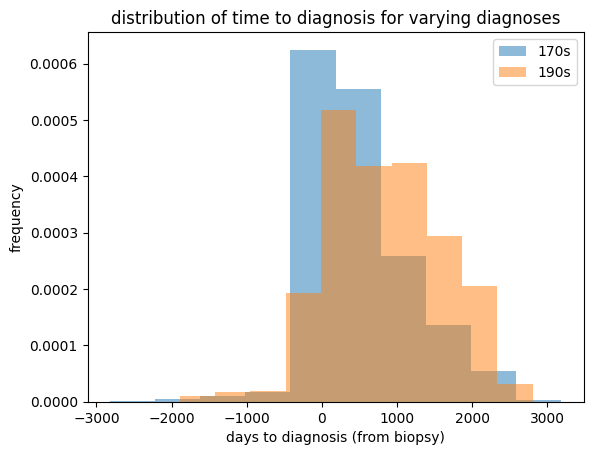

In [ ]:
metastatic_dx_df["truncated_icd9"] = metastatic_dx_df["icd9"].apply(
    lambda x: math.floor(x)
)
primary_metastatic = metastatic_dx_df[metastatic_dx_df["truncated_icd9"] <= 175][
    "time_to_dx"
]
secondary_metastatic = metastatic_dx_df[metastatic_dx_df["truncated_icd9"] > 190][
    "time_to_dx"
]
plt.hist(primary_metastatic, label="170s", alpha=0.5, density=True)
plt.hist(secondary_metastatic, label="190s", alpha=0.5, density=True)
plt.title("distribution of time to diagnosis for varying diagnoses")
plt.xlabel("days to diagnosis (from biopsy)")
plt.ylabel("frequency")
plt.legend();

Below we examine some summary statistics for `outcomes.csv`.

In [ ]:
print("BASIC SUMMARY STATISTICS FOR OURCOMES.CSV")
print("{num_rows} biopsies are recorded".format(num_rows=outcomes_df.shape[0]))
print(
    "{mortality} samples were recorded to have deceased".format(
        mortality=np.sum(outcomes_df["mortality"] == 1)
    )
)
print(
    "{metastasis} samples were recorded to have a metastatic diagnosis".format(
        metastasis=np.sum(outcomes_df["strict_metastatic_dx"] == 1)
    )
)

BASIC SUMMARY STATISTICS FOR OURCOMES.CSV
3256 biopsies are recorded
292 samples were recorded to have deceased
267 samples were recorded to have a metastatic diagnosis


Below we plot a histogram displaying the `stage` categorical variable in `outcomes.csv`. We simplify the categories to fall under I - IV by removing the additional A, B, C signifiers that were on the end of these values.

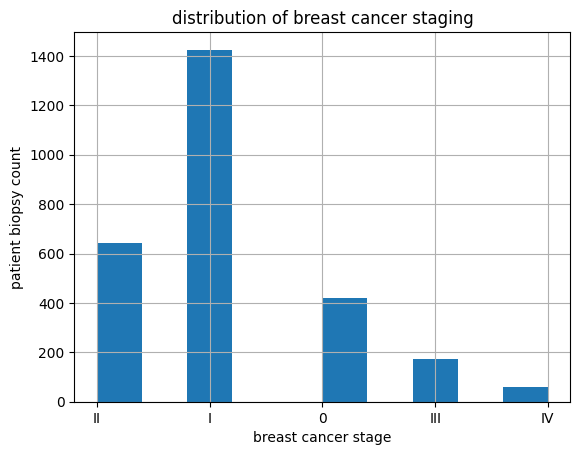

In [ ]:
staged_outcomes_df = outcomes_df.copy()
staged_outcomes_df["truncated_stage"] = staged_outcomes_df["stage"].str.replace(
    "(A|B|C)", "", regex=True
)
staged_outcomes_df["truncated_stage"].hist()
plt.title("distribution of breast cancer staging")
plt.ylabel("patient biopsy count")
plt.xlabel("breast cancer stage");

In [ ]:
# Load the necessary data
slide_biopsy_map_fp = os.path.join(table_dir, "slide-biopsy-map.csv")
slide_biopsy_map_df = pd.read_csv(slide_biopsy_map_fp)

# Create a new DataFrame to store the mapping between slide and biopsy
slide_biopsy_mapping_df = slide_biopsy_map_df[["slide_id", "biopsy_id"]]

# Load the "outcomes.csv" file
outcomes_fp = os.path.join(table_dir, "outcomes.csv")
outcomes_df = pd.read_csv(outcomes_fp)

# Select the relevant columns from the outcomes DataFrame
selected_outcomes_columns = [
    "biopsy_id",
    "case_year",
    "patient_ngsci_id",
    "strict_metastatic_dx",
    "strict_metastatic_dx_dt",
    "biopsy_dt",
]

# Merge the slide-to-biopsy mapping DataFrame with the outcomes DataFrame
slide_biopsy_mapping_df = slide_biopsy_mapping_df.merge(
    outcomes_df[selected_outcomes_columns],
    on="biopsy_id",
    how="left",
)

# Display the new DataFrame
slide_biopsy_mapping_df.head()


,slide_id,biopsy_id,case_year,patient_ngsci_id,strict_metastatic_dx,strict_metastatic_dx_dt,biopsy_dt
0,4716c9f5-1eba-444a-9658-39c0cab80f05,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
1,7787542f-9bea-419b-b3fd-84de67ddc42e,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
2,cd87bcbf-9328-4747-8a05-4f14740bcf2f,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
3,6d9c5580-246b-4c29-a61f-674a2c07a556,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
4,d9b7ae2c-bb42-434a-93a4-70fe23e7f282,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15


In [ ]:
len(slide_biopsy_mapping_df['slide_id'].unique())

52262

In [ ]:
# Assuming you have a DataFrame named df
df = slide_biopsy_mapping_df
total_metastatic_dx = df["strict_metastatic_dx"].sum()

print("Total Metastatic Diagnoses:", total_metastatic_dx)

Total Metastatic Diagnoses: 3910


In [ ]:
def show_slides_for_slide_id(slide_id, columns=3):
    slide_path = get_slide_file_path(slide_id)
    preview_image = preview_slide(slide_path)

    if preview_image is not None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        ax.imshow(preview_image)
        ax.set_title(slide_id)
        ax.axis("off")
    else:
        print(f"No image found for slide ID: {slide_id}")

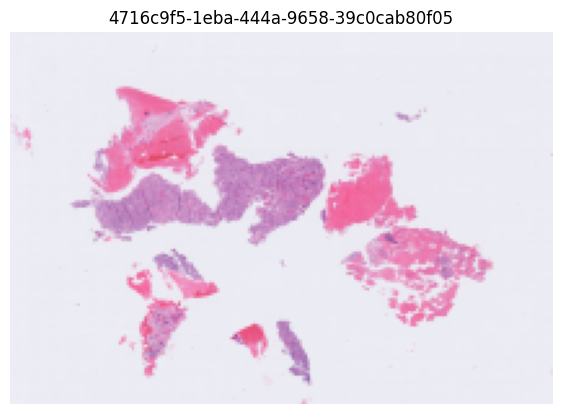

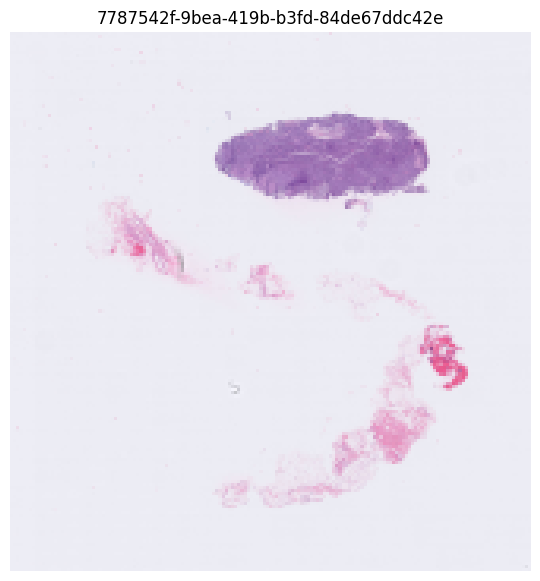

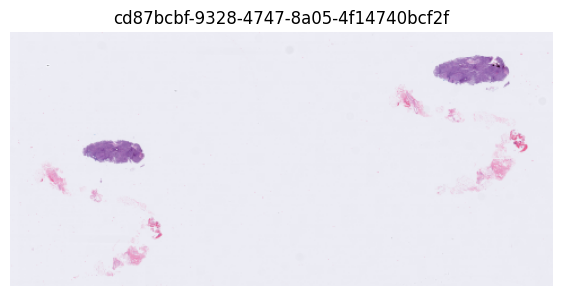

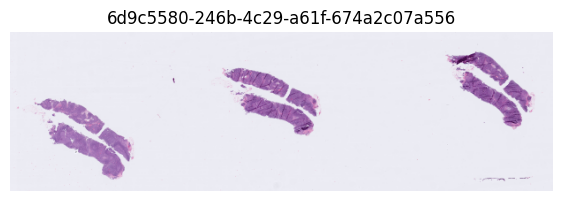

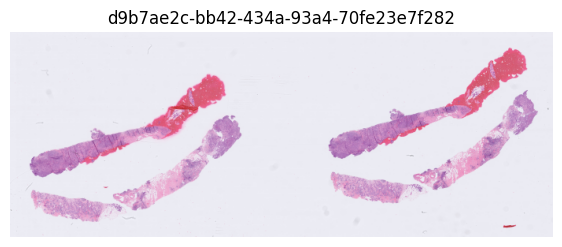

In [ ]:
# Get the first 5 unique slide IDs from the DataFrame
first_5_slide_ids = slide_biopsy_map_df["slide_id"].unique()[:5]

# Display the images for the first 5 slide IDs one by one
for slide_id in first_5_slide_ids:
    show_slides_for_slide_id(slide_id, columns=1)

In [ ]:
mask = slide_biopsy_mapping_df["strict_metastatic_dx_dt"] < slide_biopsy_mapping_df["biopsy_dt"]

# Use the mask to filter and keep only the rows where the condition is False (i.e., dx_dt is not before biopsy_dt)
filtered_df = slide_biopsy_mapping_df[~mask]

# Display the filtered DataFrame
filtered_df.head()

,slide_id,biopsy_id,case_year,patient_ngsci_id,strict_metastatic_dx,strict_metastatic_dx_dt,biopsy_dt
0,4716c9f5-1eba-444a-9658-39c0cab80f05,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
1,7787542f-9bea-419b-b3fd-84de67ddc42e,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
2,cd87bcbf-9328-4747-8a05-4f14740bcf2f,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
3,6d9c5580-246b-4c29-a61f-674a2c07a556,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15
4,d9b7ae2c-bb42-434a-93a4-70fe23e7f282,00047e6d-cf9e-41f8-8901-eb9b0fe155a6,2017,e5289eb8-ea32-41be-a74e-b11d64aa535a,0,NaN,2117-03-15


In [ ]:
len(filtered_df)

51487

In [ ]:
final_df = filtered_df.head(500)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import openslide
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Assuming df, get_slide_file_path, and preview_slide functions are defined

# Parameters

image_paths = final_df["slide_id"].tolist()
labels = final_df["strict_metastatic_dx"].tolist()
batch_size = 32
num_epochs = 10

def process_path(slide_id):
        slide_path = get_slide_file_path(slide_id)
        preview_image = preview_slide(slide_path)
        if preview_image is not None:
            image = np.array(preview_image)  # Convert to numpy array
            image = tf.image.resize(image, (224, 224))
            return image

# Creating TensorFlow Dataset
def create_dataset(image_paths):
    return [process_path(image_paths[i]) for i in range(len(image_paths))]

images = np.array(create_dataset(image_paths))
print("Images Uploaded")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization here
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization here
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
learning_rate = 0.01
model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Assuming train_dataset and test_dataset are tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(len(X_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Include Early Stopping callback if desired
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, class_weight=class_weight_dict, callbacks=[early_stopping])

# Get predictions
y_pred_prob = model.predict(test_dataset)
y_pred_classes = (y_pred_prob > 0.35).astype(int).reshape(-1)

# Convert y_test to numpy array for metrics calculation
y_true = np.array(y_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)

# Print evaluation metrics
print(f"Accuracy: {accuracy*100}%")

Images Uploaded
Epoch 1/10
16/16 [==============================] - 2s 125ms/step - loss: 2.4575 - accuracy: 0.5523
Epoch 2/10
16/16 [==============================] - 2s 118ms/step - loss: 1.9924 - accuracy: 0.6134
Epoch 3/10
16/16 [==============================] - 1s 96ms/step - loss: 1.6750 - accuracy: 0.6857
Epoch 4/10
16/16 [==============================] - 1s 85ms/step - loss: 1.3542 - accuracy: 0.7381
Epoch 5/10
16/16 [==============================] - 1s 82ms/step - loss: 1.1278 - accuracy: 0.7824
Epoch 6/10
16/16 [==============================] - 1s 79ms/step - loss: 0.9583 - accuracy: 0.8125
Epoch 7/10
16/16 [==============================] - 1s 76ms/step - loss: 0.8247 - accuracy: 0.8516
Epoch 8/10
16/16 [==============================] - 1s 74ms/step - loss: 0.7031 - accuracy: 0.8732
Epoch 9/10
16/16 [==============================] - 1s 72ms/step - loss: 0.5897 - accuracy: 0.8920
Epoch 10/10
16/16 [==============================] - 1s 70ms/step - loss: 0.5092 - accuracy